In [126]:
import math

# constant coefficients used in the function below
#
base_maintenance = 50000
external_cost_coefficient = 0.9
internal_cost_coefficient = 0.75
lifetime_coefficient = 20
market_saturation_onset = 1000000
min_investment = 100000
productivity_coefficient = 3
oversaturation_coefficient = 1.5e-07

# yearly deficit of some industrial operation, as a function of:
#    - investment x[0] = i
#    - depreciation period x[1] = d (in years): time that the equipment is in use
#
# taking into account:
#    - operating cost (repairs etc. increase if the equipment remains in use for more time)
#    - depreciation cost (investment cost per year, i.e., divided by depreciation period)
#    - production cost, including labour cost (increases if you need to rely on external providers)
#    - income from sales (this is a negative contribution to cost)
#
def investment_mco(x, debug_output):
    i, d = x[0], x[1]  # x[0] contains the investment, x[1] contains the depreciation period
    if i < 0:
        i = 0  # making a profit by "negative investment" would be nice, but does not work
    if d < 1:
        d = 1  # less than one year is not feasible
    p = max((i - min_investment)*productivity_coefficient, 0)  # production volume p determined from i
    
    production_cost = internal_cost_coefficient*p
    operating_cost = base_maintenance + lifetime_coefficient*(d**0.5)*(p**0.5)
    annual_depreciation = i/d  # the investment is done once and used over d years
    
    income_per_unit = 1.0
    if(p > market_saturation_onset):
        income_per_unit -= oversaturation_coefficient * (p - market_saturation_onset)
    sales_income = income_per_unit * p
    
    genuine_cost = operating_cost + annual_depreciation + production_cost
    sales_contribution = - sales_income
    balance = genuine_cost + sales_contribution
    
    if debug_output:
        print("total investment\ti = GBP ", round(i, 2), "\nproduction volume\tp = GBP ", \
              round(p, 2), " per year\ndepreciation period\td = ", round(d, 2), \
              " years", sep="", end="\n\n")
        print("operating cost:\tGBP ", round(operating_cost, 2), " per year\ndepreciation:\tGBP ", \
              round(annual_depreciation, 2), " per year\nprod.cost:\tGBP ", round(production_cost, 2), \
              " per year\nsales contrib.:\tGBP ", round(-sales_income, 2), \
              " per year\n==\ntotal deficit:\tGBP ", round(balance, 2), \
              " per year\n==\n", sep="", end="\n")
    
    y = [genuine_cost, sales_contribution]
    return y

# the first argument, x, is a list containing the parameter values
# the second argument, w, is a list containing the weights associated with each of the objectives
#
def investment_linear_combination(x, w):
    combined_cost = 0
    y = investment_mco(x, False)
    for i in range(min(len(y), len(w))):
        combined_cost += w[i]*y[i]
    return combined_cost

# the first argument, x, is a list containing the parameter values
# the second argument, yoff, is a list containing hyperboxing offsets for the optimization criteria
#
def investment_hyperboxing(x, yoff):
    y = investment_mco(x, False)
    ymax_shifted = -math.inf
    for i in range(min(len(y), len(yoff))):
        yi_shifted = y[i] - yoff[i]
        if yi_shifted > ymax_shifted:
            ymax_shifted = yi_shifted
    return ymax_shifted

In [38]:
# example parameter choices that yield a deficit;
# we would like to see a profit (negative deficit) instead
#
x = [1.1*min_investment, 7]

our_deficit = investment_mco(x, True)
print("Output from multicriteria cost function:", our_deficit)

linear_combination_1_1 = investment_linear_combination(x, [1, 1])
print("Output from 1:1 addition of the two cost measures:", linear_combination_1_1)

total investment	i = GBP 110000.0
production volume	p = GBP 30000.0 per year
depreciation period	d = 7 years

operating cost:	GBP 59165.15 per year
depreciation:	GBP 15714.29 per year
prod.cost:	GBP 22500.0 per year
sales contrib.:	GBP -30000.0 per year
==
total deficit:	GBP 67379.44 per year
==

Output from multicriteria cost function: [97379.43710419742, -30000.000000000044]
Output from 1:1 addition of the two cost measures: 67379.43710419738


In [127]:
import scipy.optimize as opt

# the arguments are the initial point x0 and the weights w
#
def investment_optimization_wrapper(x0, w):
    # below we define a function inside this function, for which w is fixed;
    # then, only the list x remains as an argument
    def fixed_weight_cost_function(x):
        return investment_linear_combination(x, w)
    
    # the function defined above has the right format to be handed over to opt.minimize
    local_minimum = opt.minimize(fixed_weight_cost_function, x0, method='nelder-mead', \
                                 options={'xatol': 0.0001})
    return list(local_minimum.x)

# the arguments are the initial point x0 and the offsets yoff
#
def investment_hyperboxing_wrapper(x0, yoff):
    # below we define a function inside this function, for which yoff is fixed;
    # then, only the list x remains as an argument
    def fixed_offset_cost_function(x):
        return investment_hyperboxing(x, yoff)
    
    # the function defined above has the right format to be handed over to opt.minimize
    local_minimum = opt.minimize(fixed_offset_cost_function, x0, method='nelder-mead', \
                                 options={'xatol': 0.0001})
    return list(local_minimum.x)

In [50]:
initial_point = [1.1*min_investment, 7]
weight = [1, 1]

optimum_1_1 = investment_optimization_wrapper(initial_point, weight)

print("Optimum with respect to 1:1 addition of the two cost measures:")
opt_deficit_1_1 = investment_mco(optimum_1_1, True)
print("Output from multicriteria cost function:", opt_deficit_1_1)
weighted_cost_1_1 = investment_linear_combination(optimum_1_1, weight)
print("Output from [1:1] weighted addition of the two cost measures:", weighted_cost_1_1)

Optimum with respect to 1:1 addition of the two cost measures:
total investment	i = GBP 478041.2
production volume	p = GBP 1134123.6 per year
depreciation period	d = 12.63 years

operating cost:	GBP 125695.82 per year
depreciation:	GBP 37847.91 per year
prod.cost:	GBP 850592.7 per year
sales contrib.:	GBP -1111306.69 per year
==
total deficit:	GBP -97170.26 per year
==

Output from multicriteria cost function: [1014136.4315370913, -1111306.6897637006]
Output from [1:1] weighted addition of the two cost measures: -97170.25822660932


In [92]:
# do the same as above, for 1:2 weighting
#
initial_point = [1.1*min_investment, 7]
weight = [1, 2]

optimum_1_2 = investment_optimization_wrapper(initial_point, weight)

print("Optimum with respect to 1:2 addition of the two cost measures:")
opt_deficit_1_2 = investment_mco(optimum_1_2, True)
print("Output from multicriteria cost function:", opt_deficit_1_2)

Optimum with respect to 1:2 addition of the two cost measures:
total investment	i = GBP 935234.0
production volume	p = GBP 2505701.99 per year
depreciation period	d = 15.17 years

operating cost:	GBP 173304.77 per year
depreciation:	GBP 61652.39 per year
prod.cost:	GBP 1879276.49 per year
sales contrib.:	GBP -1939775.92 per year
==
total deficit:	GBP 174457.74 per year
==

Output from multicriteria cost function: [2114233.6580345, -1939775.9202451487]


In [218]:
import numpy as np

m = 2  # number of parameters
n = 2  # number of objectives

# contains Pareto optimal parameterizations, in parameter space;
# formatted such that it can be passed on to seaborn
pareto_optimal_parameters = [[] for i in range(m)]
linear_pareto_optimal_parameters = [[] for i in range(n)]
hyperboxing_pareto_optimal_parameters = [[] for i in range(n)]
profitable_pareto_optimal_parameters = [[] for i in range(n)]

# contains the points on the Pareto front, in objective space;
# formatted such that it can be passed on to seaborn
pareto_optimal_compromises = [[] for i in range(n)]
linear_pareto_optimal_compromises = [[] for i in range(n)]
hyperboxing_pareto_optimal_compromises = [[] for i in range(n)]
profitable_pareto_optimal_compromises = [[] for i in range(n)]

# now we determine Pareto optimal solutions from a sequence of linear combinations for the two criteria
#
step = 0.001
initial_point = [1.1*min_investment, 7]

for w1 in np.arange(step, 1, step):
    weight = [1.0 - w1, w1]
    optimum = investment_optimization_wrapper(initial_point, weight)
    cost_measures = investment_mco(optimum, False)
    for i in range(m):
        pareto_optimal_parameters[i].append(optimum[i])
        linear_pareto_optimal_parameters[i].append(optimum[i])
        if sum(cost_measures) < 0:
            profitable_pareto_optimal_parameters[i].append(optimum[i])
    for i in range(n):
        pareto_optimal_compromises[i].append(cost_measures[i])
        linear_pareto_optimal_compromises[i].append(cost_measures[i])
        if sum(cost_measures) < 0:
            profitable_pareto_optimal_compromises[i].append(cost_measures[i])

# next we apply hyperboxing to detect concave regions
#
for y0off in range(-2000000, 2000000, 10000):
    optimum = investment_hyperboxing_wrapper(initial_point, [y0off, 0])
    cost_measures = investment_mco(optimum, False)
    for i in range(m):
        pareto_optimal_parameters[i].append(optimum[i])
        hyperboxing_pareto_optimal_parameters[i].append(optimum[i])
        if sum(cost_measures) < 0:
            profitable_pareto_optimal_parameters[i].append(optimum[i])
    for i in range(n):
        pareto_optimal_compromises[i].append(cost_measures[i])
        hyperboxing_pareto_optimal_compromises[i].append(cost_measures[i])
        if sum(cost_measures) < 0:
            profitable_pareto_optimal_compromises[i].append(cost_measures[i])

<AxesSubplot:xlabel='cost measure y[0]: overall expenses', ylabel='cost measure y[1]: sales contribution'>

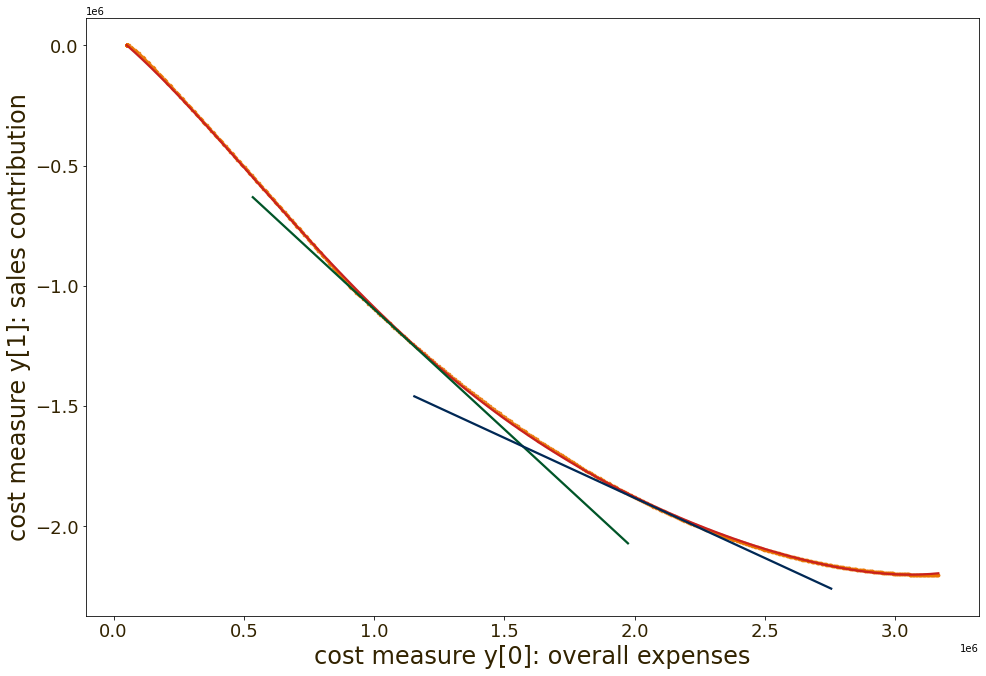

In [198]:
# visualize the whole Pareto front
#
import seaborn as sbn
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(16, 11)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("cost measure y[0]: overall expenses", fontsize=24, color="#322300")
ax.set_ylabel("cost measure y[1]: sales contribution", fontsize=24, color="#322300")

# draw the points on the Pareto front jointly with a fifth-order regression
#
sbn.regplot(x=pareto_optimal_compromises[0], y=pareto_optimal_compromises[1], \
            order = 5, scatter_kws={'s':7, 'color': '#ea7500'}, line_kws={"color": "#c9211e"})

# for orientation purposes, now also show the tangent at 1:1 weighting
#
y0_tangent_at_1_1_weight = [opt_deficit_1_1[0] + offset for offset in range(-480000, 960001, 160000)]
y1_tangent_at_1_1_weight = [opt_deficit_1_1[1] - offset for offset in range(-480000, 960001, 160000)]
sbn.regplot(x=y0_tangent_at_1_1_weight, y=y1_tangent_at_1_1_weight, \
            order = 1, scatter_kws={'s':0, 'color': '#005528'}, line_kws={"color": "#005528"})

# now also include the tangent at 1:2 weighting
y0_tangent_at_1_2_weight = [opt_deficit_1_2[0] + 2*offset for offset in range(-480000, 320001, 160000)]
y1_tangent_at_1_2_weight = [opt_deficit_1_2[1] - offset for offset in range(-480000, 320001, 160000)]
sbn.regplot(x=y0_tangent_at_1_2_weight, y=y1_tangent_at_1_2_weight, \
            order = 1, scatter_kws={'s':0, 'color': '#002855'}, line_kws={"color": "#002855"})

<AxesSubplot:xlabel='parameter x[0]: investment', ylabel='parameter x[1]: depreciation period'>

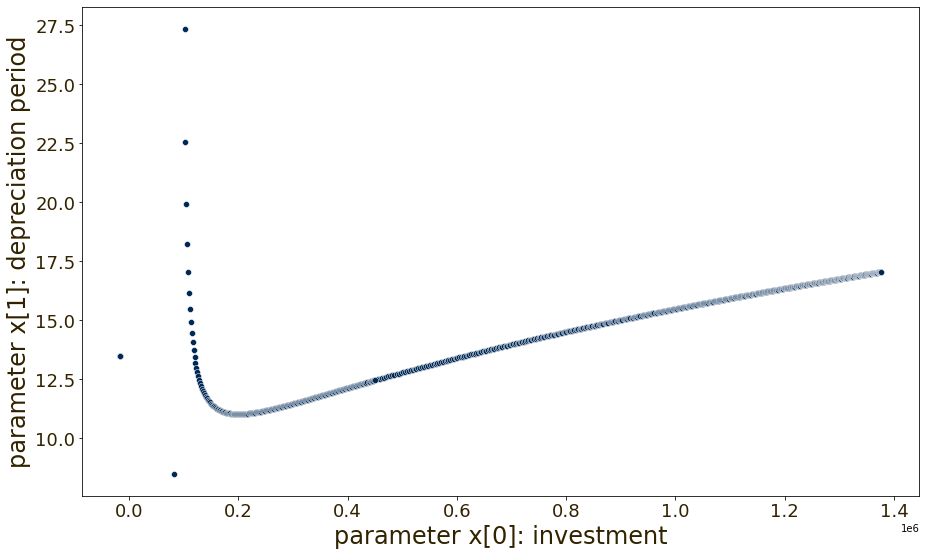

In [190]:
import pandas as pd

# now visualize the Pareto-optimal parameterizations
#
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("parameter x[0]: investment", fontsize=24, color="#322300")
ax.set_ylabel("parameter x[1]: depreciation period", fontsize=24, color="#322300")

# draw the Pareto optimal points in parameter space
#
# sbn.regplot(x=linear_pareto_optimal_parameters[0], y=linear_pareto_optimal_parameters[1], \
#             order = 3, scatter_kws={'s':7, 'color': '#002855'}, line_kws={"color": "#2f3ef0"})
#
param_data = {'x0': pareto_optimal_parameters[0], 'x1': pareto_optimal_parameters[1]}
param_frame = pd.DataFrame(param_data)
sbn.scatterplot(data=param_frame, x='x0', y='x1', color="#002855")

# # draw only the part obtained from linear combinations
# #
# sbn.regplot(x=linear_pareto_optimal_parameters[0], y=linear_pareto_optimal_parameters[1], \
#             order = 3, scatter_kws={'s':7, 'color': '#002855'}, line_kws={"color": "#2f3ef0"})


<AxesSubplot:xlabel='cost measure y[0]: expenses', ylabel='cost measure y[1]: sales contribution'>

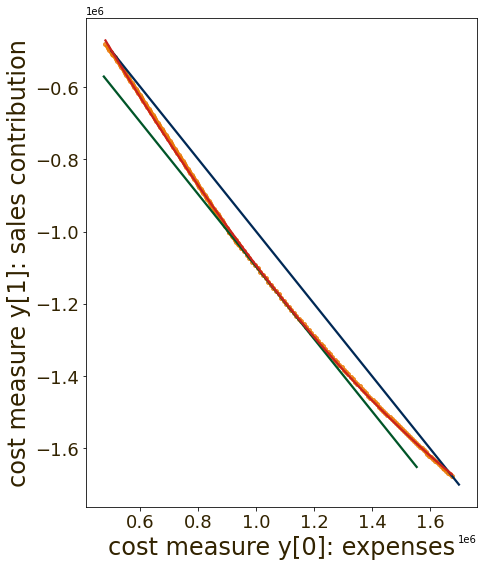

In [215]:
# visualize the Pareto front, profitable part only
#
import seaborn as sbn
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(7, 9)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("cost measure y[0]: expenses", fontsize=24, color="#322300")
ax.set_ylabel("cost measure y[1]: sales contribution", fontsize=24, color="#322300")

# show the zero net deficit line
#
y0_zero_deficit = [offset for offset in range(500000, 1700001, 400000)]
y1_zero_deficit = [-offset for offset in range(500000, 1700001, 400000)]
sbn.regplot(x=y0_zero_deficit, y=y1_zero_deficit, \
            order = 1, scatter_kws={'s':0, 'color': '#002855'}, line_kws={"color": "#002855"})

# for orientation purposes, now also show the tangent at 1:1 weighting
#
y0_tangent_at_1_1_weight = [opt_deficit_1_1[0] + offset for offset in range(-540000, 540001, 60000)]
y1_tangent_at_1_1_weight = [opt_deficit_1_1[1] - offset for offset in range(-540000, 540001, 60000)]
sbn.regplot(x=y0_tangent_at_1_1_weight, y=y1_tangent_at_1_1_weight, \
            order = 1, scatter_kws={'s':0, 'color': '#005528'}, line_kws={"color": "#005528"})

# draw the points on the profitable part of the Pareto front, jointly with a quadratic fit
#
sbn.regplot(x=profitable_pareto_optimal_compromises[0], y=profitable_pareto_optimal_compromises[1], \
            order = 2, scatter_kws={'s':16, 'color': '#ea7500'}, line_kws={"color": "#c9211e"})

<AxesSubplot:xlabel='parameter x[0]: investment', ylabel='parameter x[1]: depreciation period'>

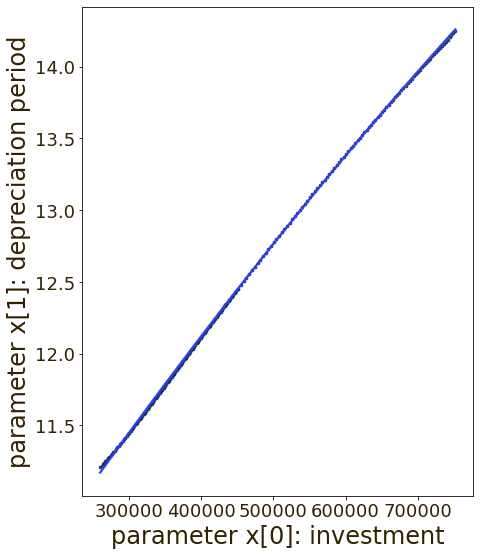

In [214]:
import pandas as pd

# now visualize the Pareto-optimal parameterizations
#
fig, ax = plt.subplots()
fig.set_size_inches(7, 9)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("parameter x[0]: investment", fontsize=24, color="#322300")
ax.set_ylabel("parameter x[1]: depreciation period", fontsize=24, color="#322300")

# draw only the profitable Pareto optimal points in parameter space, with a quadratic fit
#
sbn.regplot(x=profitable_pareto_optimal_parameters[0], y=profitable_pareto_optimal_parameters[1], \
            order = 2, scatter_kws={'s':7, 'color': '#002855'}, line_kws={"color": "#2f3ef0"})